In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
IMG_SIZE = 250
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [3]:
# returns a "tf.data.Dataset" from image files in a directory
ds = tf.keras.preprocessing.image_dataset_from_directory( # shuffle=True; by default
    "Potato_Data",
    seed = 1233,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
classes = ds.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

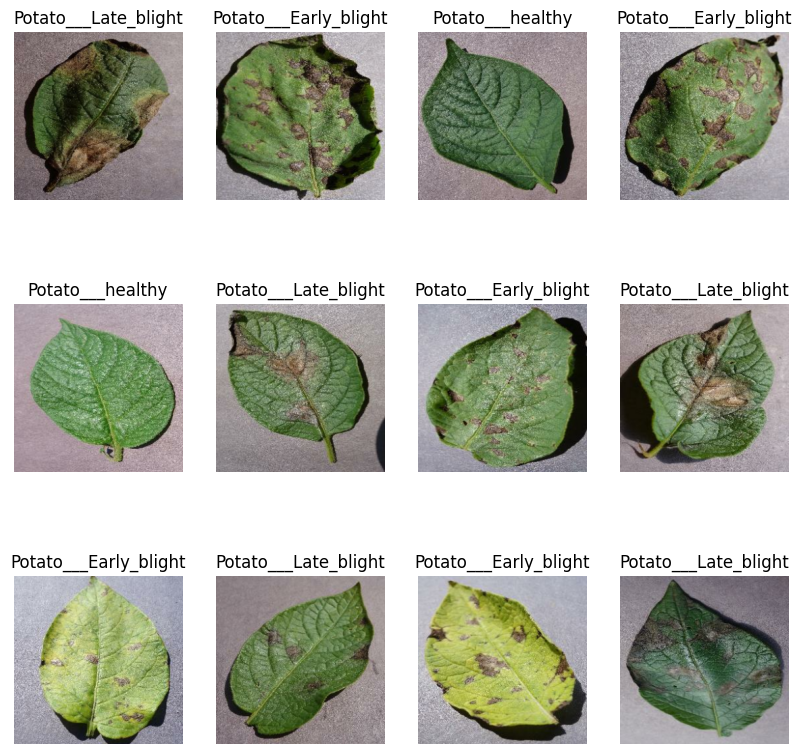

In [5]:
plt.figure(figsize=(10, 10))
for img_batch, labels in ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
# resizing and scaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    #layers.BatchNormalization(),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.BatchNormalization(),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.BatchNormalization(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.BatchNormalization(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.BatchNormalization(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 250, 250, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 248, 248, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 124, 124, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 122, 122, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 61, 61, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 59, 59, 64)         

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
54/54 [==============================] - 202s 4s/step - loss: 0.9110 - accuracy: 0.4965 - val_loss: 0.7910 - val_accuracy: 0.4740
Epoch 2/5
54/54 [==============================] - 195s 4s/step - loss: 0.6931 - accuracy: 0.6892 - val_loss: 0.6071 - val_accuracy: 0.7344
Epoch 3/5
54/54 [==============================] - 190s 4s/step - loss: 0.4932 - accuracy: 0.7830 - val_loss: 0.5210 - val_accuracy: 0.7760
Epoch 4/5
54/54 [==============================] - 191s 4s/step - loss: 0.3667 - accuracy: 0.8495 - val_loss: 0.3471 - val_accuracy: 0.8646
Epoch 5/5
54/54 [==============================] - 190s 4s/step - loss: 0.3506 - accuracy: 0.8478 - val_loss: 0.3851 - val_accuracy: 0.8802


In [16]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
type(history.history['loss'])

list

In [19]:
len(history.history['loss'])

5

In [20]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9109632968902588,
 0.6930737495422363,
 0.49323391914367676,
 0.36671650409698486,
 0.3506210744380951]

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

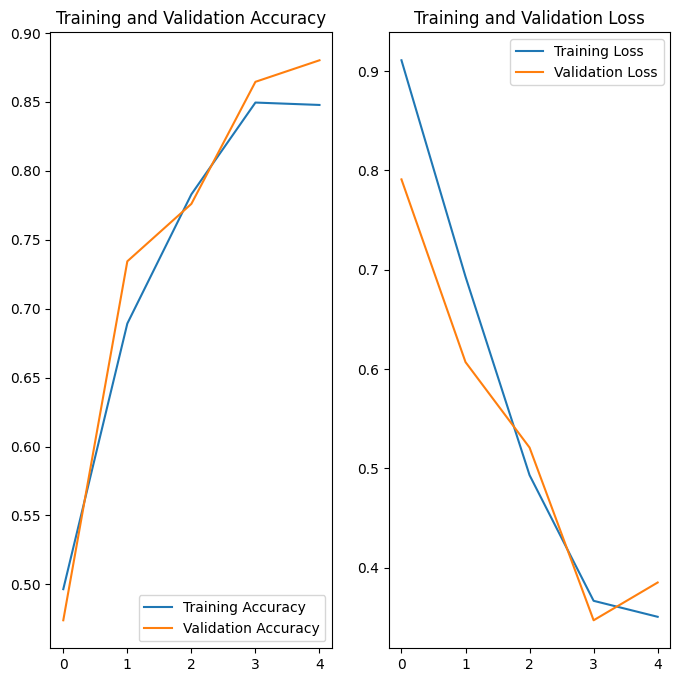

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 996ms/step
predicted label: Potato___Early_blight


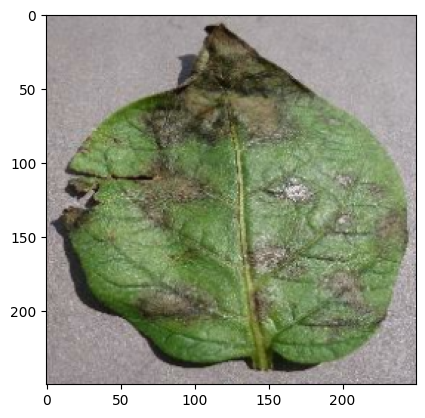

In [24]:
# Run prediction on a sample image

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [25]:
# Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 77ms/step


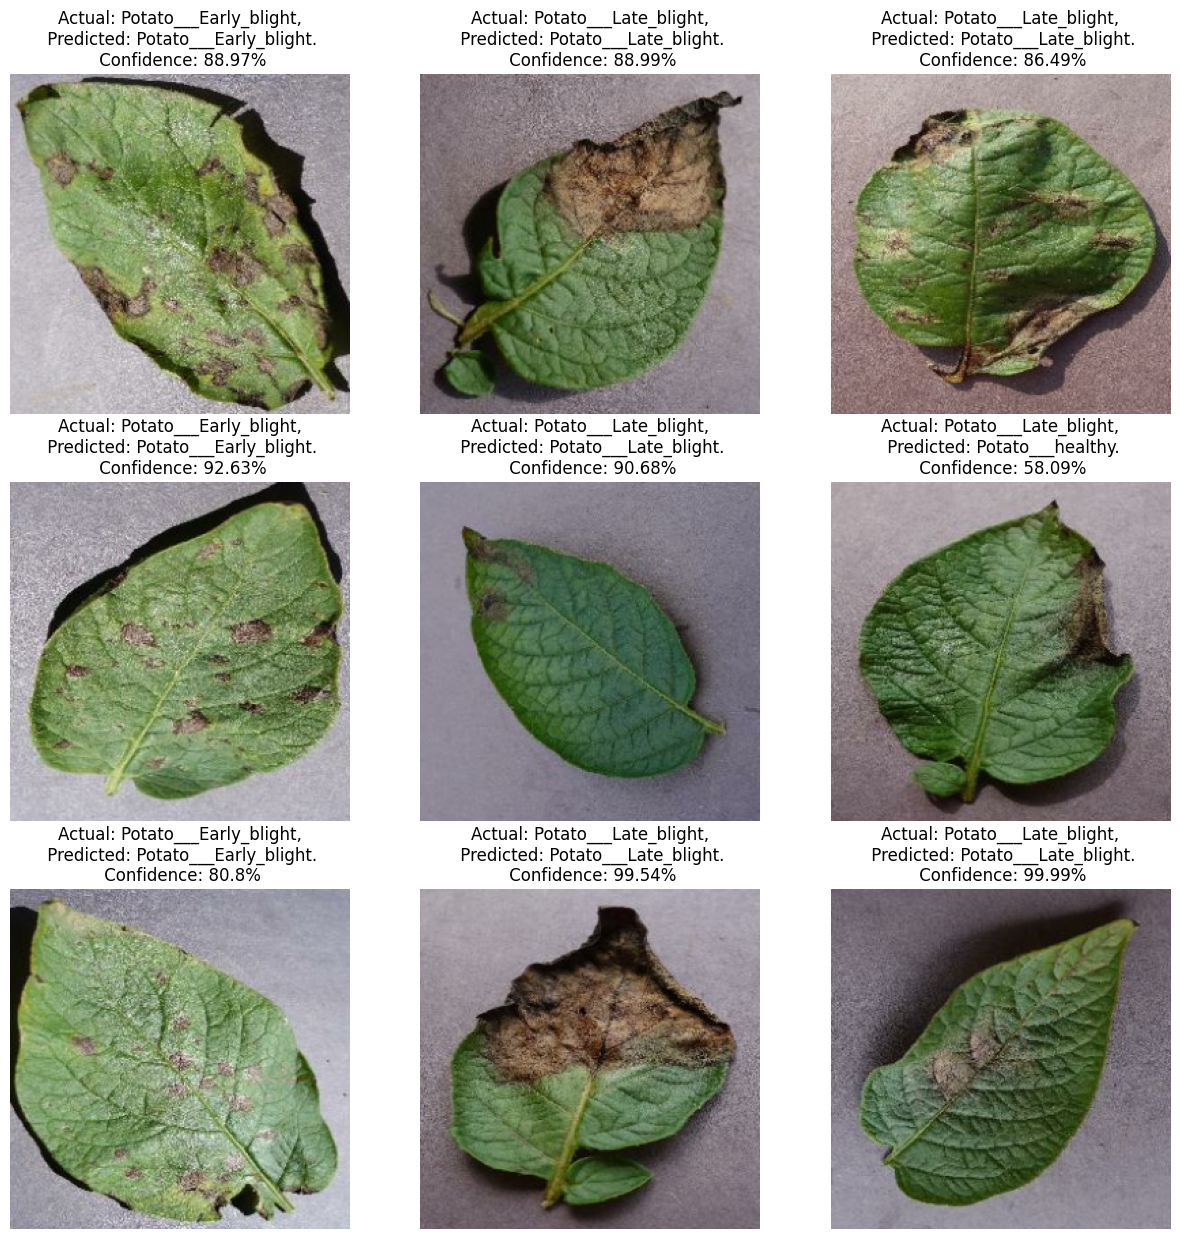

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [53]:
# saving the model
model.save("potatoes.keras")

In [26]:
model.save("model.h5")

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
